## Background & Aims

Katen Project Goal:

Examine the activity of histone modifications: 
- across various tissues and cell lines
- across different forms of histone modification
- in 17q locus of asthma (most significant locus of asthma)

Longer-Term Goal:
Train genetic predictors of histone modifications 
- can be combined with GWAS of asthma to identify loci where histone modification may play a role in asthma etiology


"The 17q21 asthma susceptibility locus is located between 35.0 and 35.5 Mb on chromosome 17 and contains at least 15 genes. To date, however, asthma-associated SNPs have been associated with the expression of only four of these genes: 
(i) Ikaros zinc finger protein 3 (IKZF3), involved with the regulation of lymphocyte development; 
(ii) Gasdermin B (GSDMB), implicated in epithelial cell barrier function; 
(iii) Mediator of RNA polymerase II transcription subunit 24 (MED24), a component of a transcriptional coactivator complex thought to be required for expression of most genes; and 
(4) ORMDL3, an endoplasmic reticulum (ER) transmembrane protein involved in regulation of sphingolipid metabolism."
Source: https://www.nature.com/articles/pr2013186

Relevant genes in the 17q21 locus: IKZF3, GSDMB, MED24, ORMDL3.
Center at GSDMB.  

Human Targets (trained ENFORMER):

https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt

Go to GeneCards for specific gene of interest (use version 19 for now, which is under "Previous Assembly").

https://www.genecards.org/cgi-bin/carddisp.pl?gene=GSDMB#:~:text=GeneCards%20Summary%20for%20GSDMB%20Gene,of%20this%20gene%20is%20GSDMA.
Not the best way to do this, but it works for now.

From GeneCards, look like this is the location:   chr17:38,060,848-38,074,888

Look at enformer.usage Jupyter notebook for the prediction and visualization of these areas.  


1) get locus center (17q)
2) extract the DNA sequence from the reference genome (part of the enformer function in the hackathon creates the genome sequence) at that locus
3) call enformer (should be just a function) and provide DNA sequence
- may want to use parsl to speed up process
4) save the output in a variable which is 5313 x 896
5) plot matrix
6) read the human_target.txt or .csv 
7) analyze the data from the matrix for indices (columns) at H3K27Ac 
- e.g. like how the hackathon extracts only column 5110
- all histone modification data will be ChIP-seq and will start with H
- H3K27ac is a marker for active enhancers and a great indicator of enhancer activity
- after enformer outputs the data, it should be just the columns corresponding to the histone modifications
8) plot H3K27Ac in LCL and in other cell types (which are in the targets file)
9) principal component analysis

## Setup

Import necessary packages.

In [2]:
import tensorflow_hub as hub # for interacting with saved models and tensorflow hub
import joblib
import gzip # for manipulating compressed files
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import pyfaidx # to index our reference genome file
import pandas as pd # for manipulating dataframes
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for plotting
import seaborn as sns # for plotting
import pickle # for saving large objects
import os, sys # functions for interacting with the operating system
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Changed the original code from !pip to %pip because only &pip allows us to import packages into the correct location (including tensorflow, which was the specific package that wasn't importing here).

In [3]:
#tensorflow import
%pip install tensorflow 
%pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

kipoiseq is a package that helps us to extract sequences from fasta files given some intervals. We will install the package.

In [5]:
%pip install kipoiseq==0.5.2 --quiet > /dev/null #changed ! in front of pip to % on polaris for package import 
# You can ignore the pyYAML error


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install Biopython #Biopython is a python package that helps us do many bioinfomatic analysis in python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


We want to define some paths to save downloaded files for the duration of this notebook. 

In [7]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1' #where DeepMind stored the enformer model
fasta_file = '/grand/TFXcan/imlab/users/srusti/enformer/data/genome.fa' #contains the reference human genome

We use B lymphoblastoid cell line predictions here because that is the cell line used to generate GEUVADIS gene expression data. You can copy the https link, paste in another tab in your browser and look through the large txt file for other tracks.

## Extracting DNA Sequence Centered at Locus

In [8]:
class FastaStringExtractor:
    def __init__(self, fasta_file):
        import pyfaidx
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    def extract(self, interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        import kipoiseq
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = kipoiseq.Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                            trimmed_interval.start + 1,
                                            trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream
    def close(self):
        return self.fasta.close()

To use the above function, first create an instance of the FastaStringExtractor object, providing a fasta file you want to use:

In [9]:
fasta_extractor_object = FastaStringExtractor(fasta_file)

Then, create an interval you want to extract the sequence from using kipoiseq (".resize" will resize the interval you provide to a length provided by "sequence_length". The new interval will be centered on the "start", "end" you provided originally ):

target_interval = kipoiseq.Interval(chrom,start,end).resize(SEQUENCE_LENGTH)

In [10]:
SEQUENCE_LENGTH = 393216
target_interval = kipoiseq.Interval('chr17', 38060848, 38074888).resize(SEQUENCE_LENGTH) #17q locus of asthma

In [11]:
target_interval

Interval(chrom='chr17', start=37871260, end=38264476, name='', strand='.', ...)

Finally, extract the sequence using the extractor object like this:

In [12]:
extracted_sequence = fasta_extractor_object.extract(target_interval)

In [13]:
#print(extracted_sequence)
len(extracted_sequence)

393216

## Call Enformer using Extracted DNA Sequence

Next, we have some functions that will help us along the way. Classes and methods defined in this code block can be found in the [original Enformer usage colab notebook](https://colab.research.google.com/github/deepmind/deepmind_research/blob/master/enformer/enformer-usage.ipynb).

**Enformer, EnformerScoreVariantsNormalized, EnformerScoreVariantsPCANormalized**

In [14]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

**One Hot Encoder**

One-Hot Encoder converts the region of the genome from letters like A, G, T, C to binary (1, 0)

In [15]:
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

Defining the Enformer model and fasta_extractor in order to run Enformer

In [16]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor(fasta_file)

Run One Hot Encoder and run enformer.

In [17]:
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

In [18]:
predictions.shape #shows that this is the 896 by 5313 matrix that Enformer outputs

(896, 5313)

## Plot Enformer Matrix (896 x 5313)

We will plot this Enformer matrix in R, so it needs to be converted to a CSV file in this notebook first. 
After saving it as a csv file, we will read the file in RStudio and visualize it using image(matrix), where "matrix" is the name of our Enformer predictions matrix (assigned as 'predictions').

In [19]:
import numpy as np

np.savetxt('/grand/TFXcan/imlab/users/srusti/enformer/data/q17_enformer.csv', predictions, delimiter=',')

To save the file from polaris directory to local directory, use the command scp:

scp sd04@polaris.alcf.anl.gov:/grand/TFXcan/imlab/users/srusti/enformer/data/q17_enformer.csv ~/localfolderpath

In [20]:
print(predictions.max())

559.0174


Attempts at making a plot of the enformer output matrix. Very computationally expensive.

In [21]:
#vmax = predictions.max()
#sns.heatmap(predictions, vmin=0, vmax=1)

## Plot Tracks

Function to plot tracks

In [22]:
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

Download targets_human.txt 

In [23]:
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt' 
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


Function to extract from dataframe based on substring

In [24]:
def idx_substr(df, column_name, substring):
    mask = df[column_name].str.contains(substring)
    return df[mask].index

In [25]:
indices = idx_substr(df_targets, 'description', 'H3K27ac')
array_h32kac = np.array(indices)
list_h32kac = array_h32kac.tolist()
print(list_h32kac)
len(list_h32kac)

[688, 705, 706, 707, 719, 724, 732, 737, 743, 752, 764, 770, 788, 817, 848, 853, 864, 1107, 1379, 1397, 1408, 1443, 1448, 1450, 1452, 1456, 1470, 1471, 1481, 1487, 1488, 1492, 1494, 1499, 1533, 1534, 1553, 1555, 1579, 1610, 1628, 1648, 1657, 1659, 1671, 1700, 1715, 1741, 1744, 1778, 1789, 1838, 1844, 1871, 1882, 1921, 1938, 1981, 2000, 2008, 2039, 2047, 2057, 2077, 2089, 2090, 2104, 2106, 2111, 2122, 2150, 2155, 2162, 2169, 2170, 2188, 2230, 2234, 2280, 2283, 2285, 2322, 2380, 2385, 2389, 2407, 2410, 2420, 2425, 2433, 2436, 2448, 2454, 2510, 2537, 2572, 2604, 2606, 2640, 2644, 2670, 2683, 2684, 2745, 2761, 2763, 2789, 2795, 2821, 2832, 2833, 2839, 2856, 2862, 2899, 2970, 2976, 2991, 2994, 3019, 3024, 3025, 3060, 3065, 3083, 3108, 3116, 3127, 3138, 3162, 3181, 3183, 3194, 3234, 3242, 3254, 3285, 3296, 3297, 3299, 3300, 3312, 3324, 3330, 3339, 3343, 3360, 3363, 3429, 3432, 3436, 3444, 3457, 3460, 3462, 3475, 3478, 3485, 3501, 3530, 3539, 3542, 3547, 3588, 3592, 3657, 3664, 3670, 3671, 36

228

The columns in the 'predictions' enformer output matrix is the same as the rows in the human targets dataframe.

In [26]:
#idk why this for loop isn't working (goal is to iterate through the list of indices and plot the tracks for each of those indices)
#for i in list_h32kac:
    #tracks = predictions[:, i]
    #plot_tracks(targets, target_interval)

Trying for loop again but with dictionary comprehension.

In [27]:
hm_targets = df_targets[df_targets["description"].str.contains("H3K27ac")]
hm_indices = hm_targets.index.to_numpy()
hm_desc = hm_targets.description

In [28]:
len(hm_desc)

228

In [29]:
print(hm_desc)

688                                  CHIP:H3K27ac:GM12878
705     CHIP:H3K27ac:endothelial cell of umbilical vei...
706                      CHIP:H3K27ac:keratinocyte female
707     CHIP:H3K27ac:mammary epithelial cell female ad...
719     CHIP:H3K27ac:fibroblast of lung female child (...
                              ...                        
4410      CHIP:H3K27ac:chorionic villus embryo (16 weeks)
4427    CHIP:H3K27ac:stomach smooth muscle female adul...
4461    CHIP:H3K27ac:right lobe of liver female adult ...
4463    CHIP:H3K27ac:ascending aorta female adult (51 ...
4477                                   CHIP:H3K27ac:RWPE2
Name: description, Length: 228, dtype: object


Taking too long to run, but worked at some point?

In [30]:
#tracks = {}
#for id, desc in zip(hm_indices, hm_desc[:30]):
    #tracks[desc] = predictions[:, id]

#plot_tracks(tracks, target_interval)

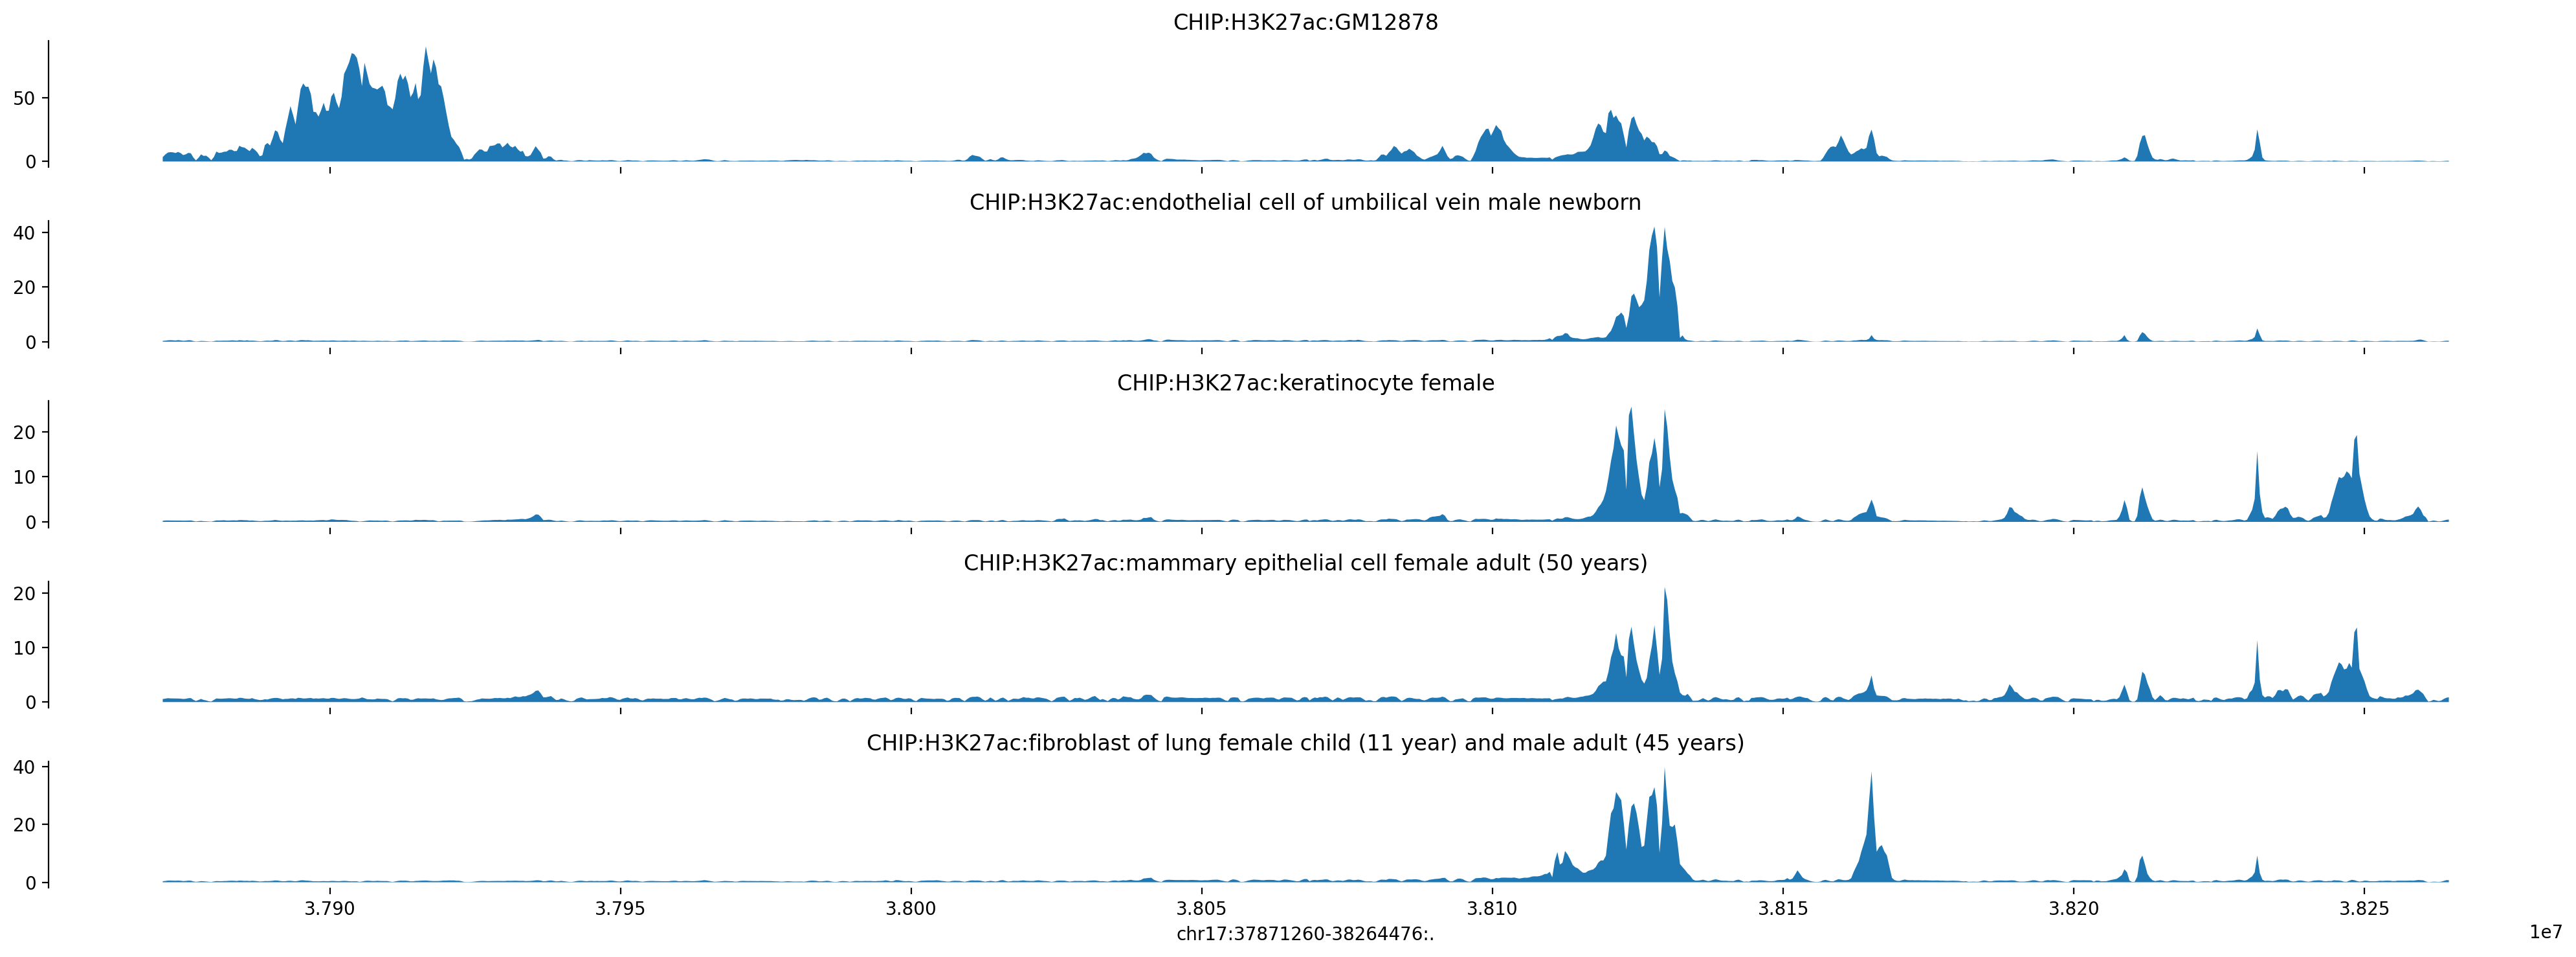

In [31]:
tracks = {}
for id, desc in zip(hm_indices, hm_desc[:5]):
    tracks[desc] = predictions[:, id]
plot_tracks(tracks, target_interval)

With the above plots, the y-axis is signal strength and the x-axis is locations along the genome. Keep in mind that the y-axis is different for each plot, so don't be misguided by that. The peaks indicate a strong signal. 

Creating new matrix of just H32Kac histone modifications.

In [32]:

def spec_matr(matrix, indices):
    selected_columns = matrix[:, indices]
    return selected_columns

hist_mat = spec_matr(predictions, hm_indices)
hist_mat

array([[3.4516914 , 0.2985052 , 0.24107991, ..., 0.1990852 , 0.72539186,
        0.46466345],
       [5.494104  , 0.36805937, 0.3042852 , ..., 0.4559467 , 0.8413158 ,
        0.57390183],
       [7.0130615 , 0.5032718 , 0.319433  , ..., 0.84562933, 0.9788086 ,
        0.63684535],
       ...,
       [0.3636821 , 0.24752413, 0.2898131 , ..., 2.8500197 , 1.4871315 ,
        0.6117047 ],
       [0.5210554 , 0.3303125 , 0.44722396, ..., 3.1198292 , 1.6201284 ,
        0.63287216],
       [0.55862504, 0.34873107, 0.5097408 , ..., 2.7830832 , 1.5329505 ,
        0.7047074 ]], dtype=float32)

Transpose Matrix

In [33]:
final_hist = hist_mat.transpose()

Conducting PCA.

In [34]:
from sklearn.decomposition import PCA

# Create an instance of PCA with the desired number of components
n_components = 2  # Specify the number of components you want to retain
pca = PCA(n_components=n_components)

# Fit the PCA model to the data
pca.fit(final_hist)

# Transform the data to the principal components
transformed_data = pca.transform(final_hist)

# Access the principal components and explained variance ratio
principal_components = pca.components_  # The principal components
explained_variance_ratio = pca.explained_variance_ratio_  # The explained variance ratio

# Print the shape of the transformed data matrix
print("Shape of transformed data:", transformed_data.shape)

Shape of transformed data: (228, 2)


In [35]:
print(transformed_data)
print(principal_components)

[[ 4.28995514e+02  2.22408295e+01]
 [-5.69233780e+01 -1.08486109e+01]
 [-4.68996277e+01 -1.38690348e+01]
 [-4.59425316e+01 -4.11521683e+01]
 [-4.39853897e+01  2.97827206e+01]
 [-5.16782341e+01 -2.73683414e+01]
 [-4.01018372e+01 -5.44727859e+01]
 [-5.65870819e+01 -4.55732632e+00]
 [-3.71870575e+01  1.40551805e-01]
 [-5.18636055e+01  2.18293514e+01]
 [-5.05065041e+01  1.34422789e+01]
 [-4.23633842e+01 -2.61845417e+01]
 [-2.54264050e+01 -1.40241289e+01]
 [-3.33490715e+01 -2.68623428e+01]
 [-4.16327744e+01 -2.23753643e+01]
 [ 2.43106827e+02 -2.46317558e+01]
 [-3.11567192e+01  5.64609241e+00]
 [-4.13941231e+01  3.40224495e+01]
 [-4.34644775e+01 -1.31832275e+01]
 [-4.33566895e+01 -6.40485458e+01]
 [-3.23970184e+01 -2.04069061e+01]
 [-4.50838013e+01 -2.66587944e+01]
 [-3.96876640e+01 -2.76188583e+01]
 [-3.15708237e+01 -2.07628269e+01]
 [-4.81661644e+01 -3.35957489e+01]
 [-3.21429291e+01  5.59894848e+00]
 [ 2.07482101e+02  3.80122147e+01]
 [-5.25212708e+01  1.01796675e+01]
 [-1.68889313e+01  1

In the code above, we import the necessary modules and create an instance of the PCA class from scikit-learn. We specify the desired number of components (n_components) as an argument. Next, we fit the PCA model to the data_matrix using the fit() method. Then, we transform the original data to the principal components using the transform() method.

You can access the principal components via the components_ attribute and the explained variance ratio via the explained_variance_ratio_ attribute of the PCA object.

Finally, we print the shape of the transformed data matrix and show the first few rows of the transformed data.

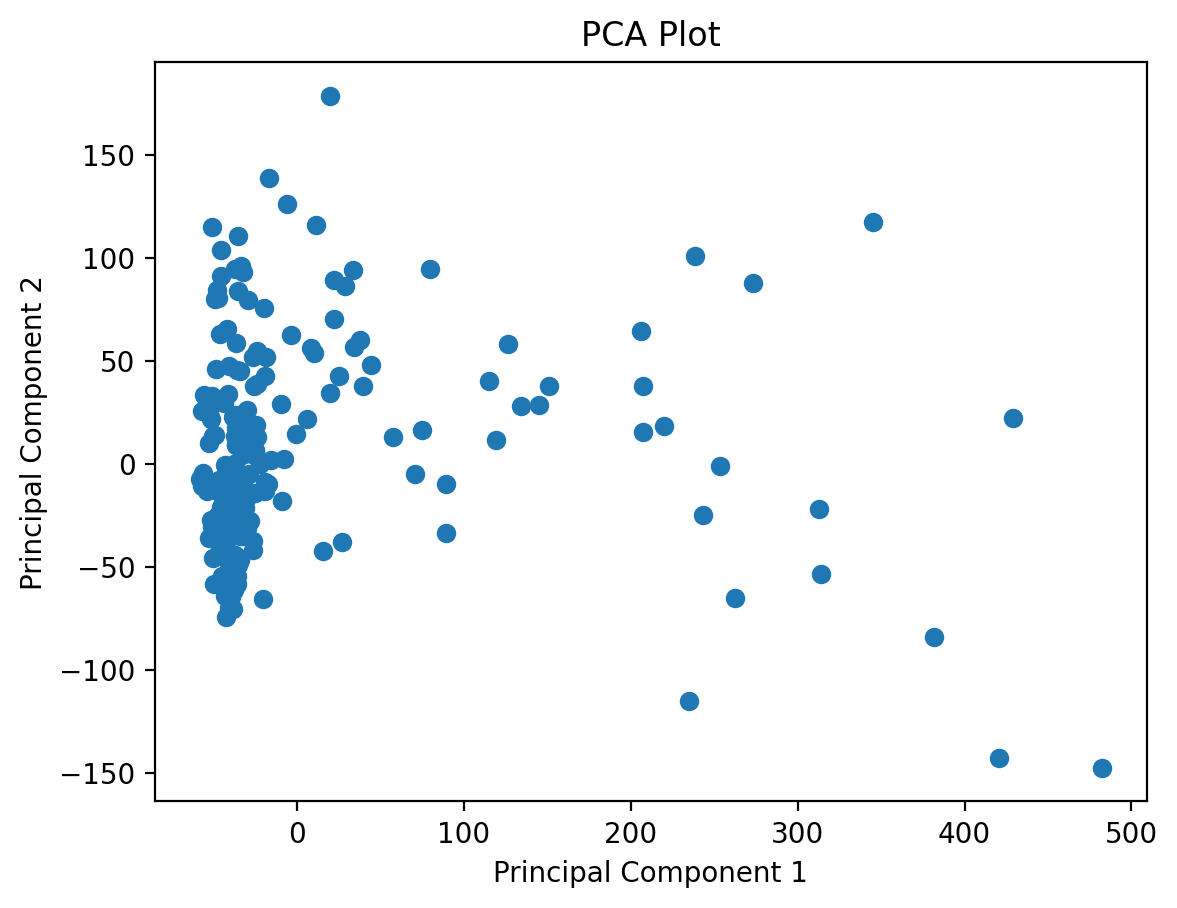

In [36]:
#producing a PCA plot

plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot")
plt.show()

**Potential further exploration at asthma locus**

- Remove outliers in data and replot
- Label some of the outliers in the PCA plot with the cell type 
- Regulatory regions (?), look at the variation in the peaks that are not at the specific locus (so at the beginning of each plot).
- Plot the peaks on the left on the PCA plot. Sum of the half of the bins for each plot and plot it on the PCA to see if there's a pattern.

## Cell Type Specific Histone Modification Analysis

Lung tissue cells:

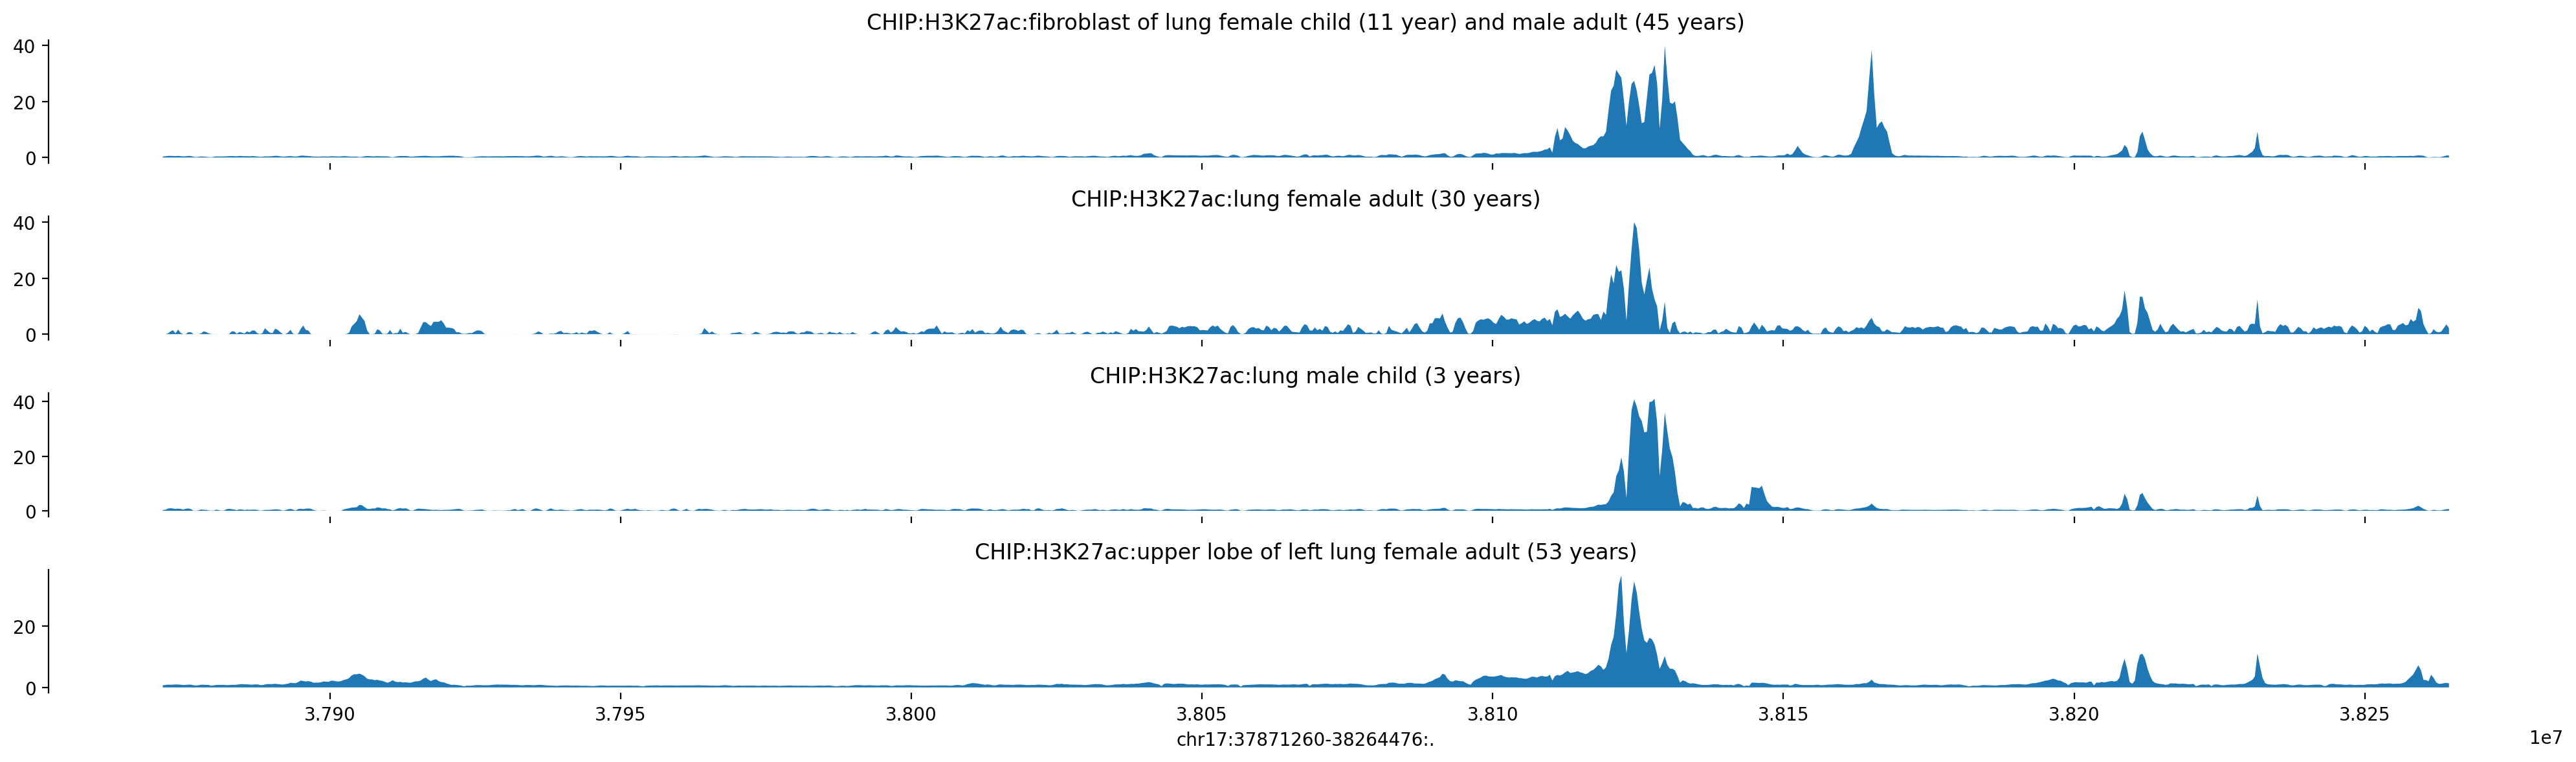

In [37]:
lung_targets = df_targets[df_targets["description"].str.contains("CHIP") & df_targets["description"].str.contains("H3K27ac") & df_targets["description"].str.contains("lung")]
lung_indices = lung_targets.index.to_numpy()
lung_desc = lung_targets.description

tracks = {}
for id, desc in zip(lung_indices, lung_desc[:10]):
    tracks[desc] = predictions[:, id]
plot_tracks(tracks, target_interval)

T cells:

TypeError: 'AxesSubplot' object is not iterable

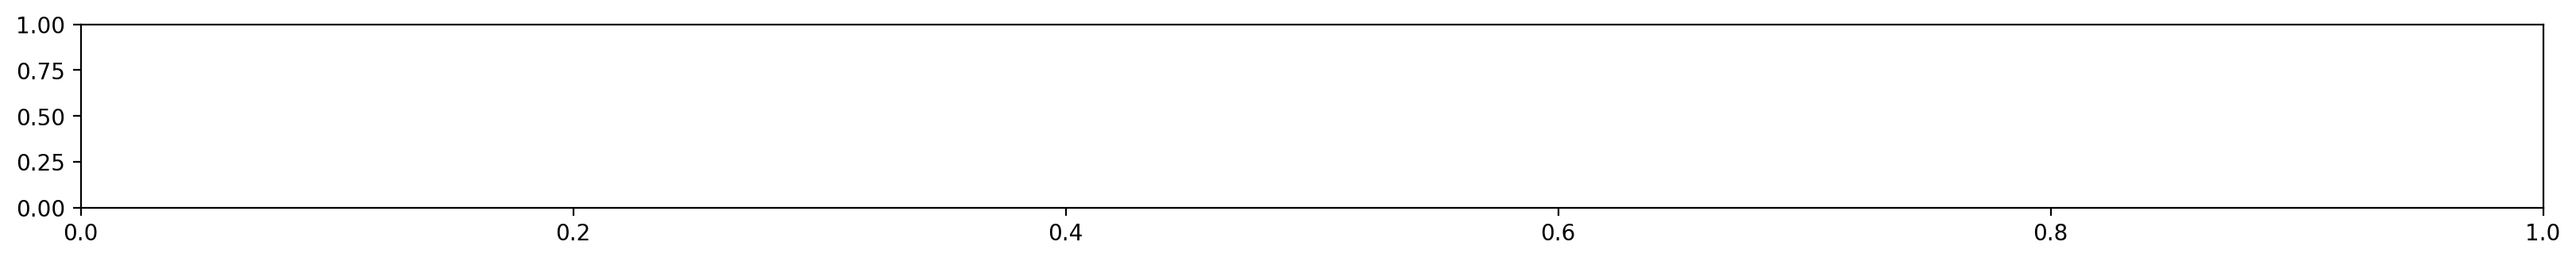

In [38]:
tcell_targets = df_targets[df_targets["description"].str.contains("CHIP") & df_targets["description"].str.contains("H3K27ac") & df_targets["description"].str.contains("T cell")]
tcell_indices = tcell_targets.index.to_numpy()
tcell_desc = tcell_targets.description

tracks = {}
for id, desc in zip(tcell_indices, tcell_desc[:1]):
    tracks[desc] = predictions[:, id]
plot_tracks(tracks, target_interval)

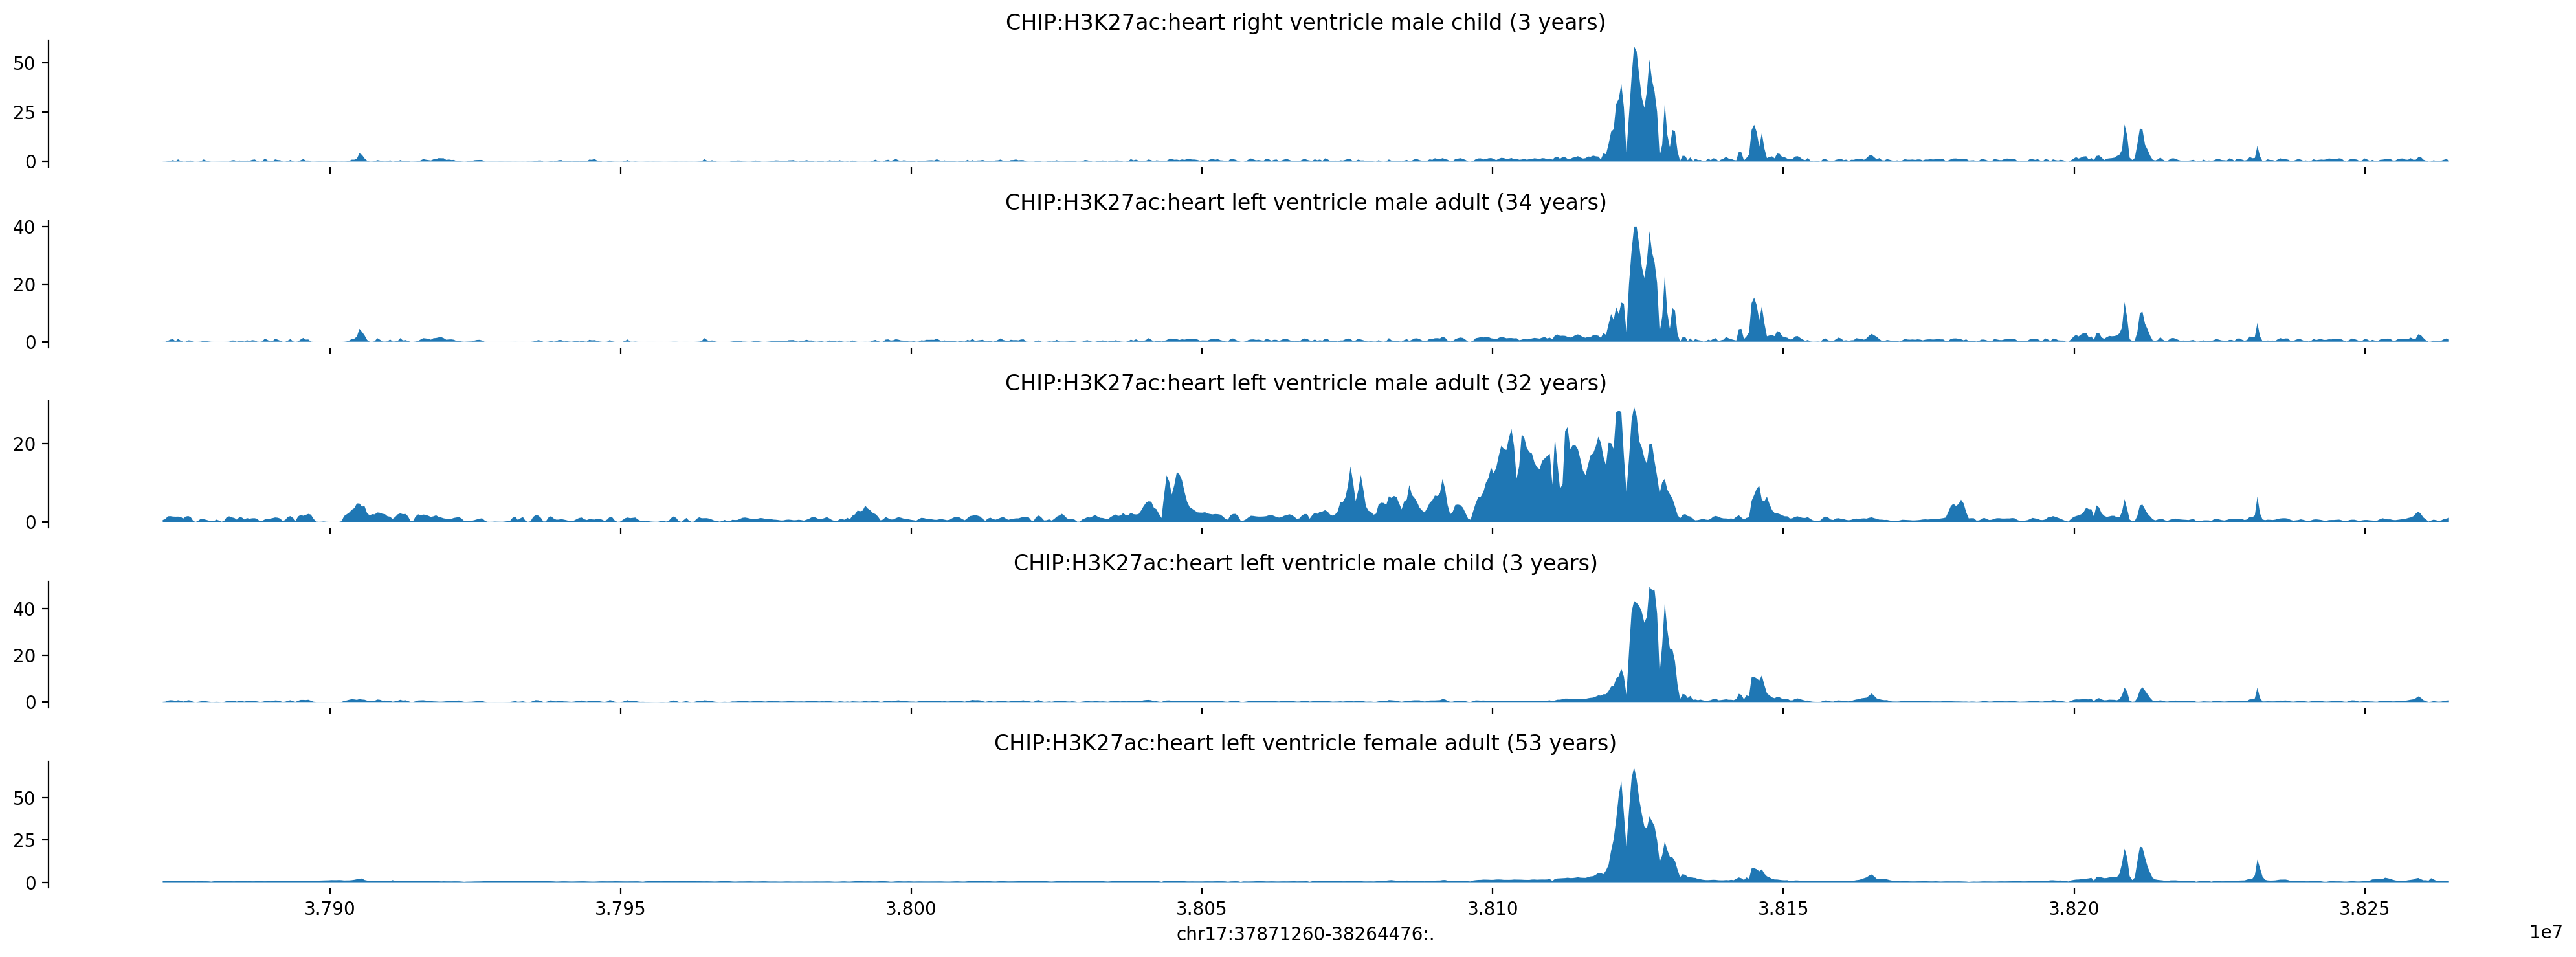

In [39]:
heart_targets = df_targets[df_targets["description"].str.contains("CHIP") & df_targets["description"].str.contains("H3K27ac") & df_targets["description"].str.contains("heart")]
heart_indices = heart_targets.index.to_numpy()
heart_desc = heart_targets.description

tracks = {}
for id, desc in zip(heart_indices, heart_desc[:5]):
    tracks[desc] = predictions[:, id]
plot_tracks(tracks, target_interval)

## Exploratory Analysis of Enformer Predictions by Haplotype Averaging

Enformer was trained with the reference genome, and with individuals of european ancestry.
We are interested to see, instead of using the reference genome, how to use an average genome across a population (population allele frequencies) with the long term goal of recognizing differences between people. This MAY make a difference in the "population-average epigenome" compared to the "regular reference" epigenome. But to do so, we need to figure out if it even makes a difference if you average the genome and run enf vs run each genome and average their outputs.

Question: is enformer linear?
To answer:
- Run enformer with one averaged haplotype and produce epigenome 1
- Run enformer with each haplotype individually and average the two matrices to produce epigenome 2
- Compare epigenome 1 with epigenome 2

## Predicting on Average Haplotype

Change the run predictions function:
Currently it is averaging the predictions from each haplotype individually. We need to change it so that it averages the haplotype before it predicts.

In [40]:
def run_hapavg_predictions(gene_intervals, tss_dataframe, individuals_list=None):
  '''
  Parameters :
    gene_intervals : the results from calling `collect_intervals`
    tss_dataframe : a list of the TSSs dataframes i.e. the TSS for the genes in the chromosomes
    individuals_list : a list of individuals on which we want to make predictions; defaults to None

  Returns :
    A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
  '''

  gene_output = dict()
  gene_predictions = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2]) # creates an interval to select the right sequences
    target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
    window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
    try:
      cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
    except:
      continue
    individual_results = dict()
    individual_prediction = dict()

    if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
      use_individuals = individuals_list
    elif isinstance(individuals_list, type(None)):
      use_individuals = cur_gene_vars.columns[4:]

    for individual in use_individuals:
      print('Currently on gene {}, and predicting on individual {}...'.format(gene, individual))
      # two haplotypes per individual
      haplo_1 = list(target_fa[:])
      haplo_2 = list(target_fa[:])

      ref_mismatch_count = 0
      for i,row in cur_gene_vars.iterrows():

        geno = row[individual].split("|")
        if (row["POS"]-window_coords.start-1) >= len(haplo_2):
          continue
        if (row["POS"]-window_coords.start-1) < 0:
          continue
        if geno[0] == "1":
          haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
        if geno[1] == "1":
          haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]
    

      # predict on the individual's two haplotypes
      prediction_1 = model.predict_on_batch(one_hot_encode("".join(haplo_1))[np.newaxis])['human'][0]
      prediction_2 = model.predict_on_batch(one_hot_encode("".join(haplo_2))[np.newaxis])['human'][0]

      haplo_avg = np.add((one_hot_encode("".join(haplo_1))[np.newaxis]), (one_hot_encode("".join(haplo_2))[np.newaxis])) / 2 #line which averages
      prediction_avg = model.predict_on_batch(haplo_avg)['human'][0]

      temp_predictions = [prediction_avg[:, 5110]]
      individual_prediction[individual] = temp_predictions

      # Calculate TSS CAGE expression which correspond to column 5110 of the predictions above
      temp_list = list()

      pred_prepared_avg = prepare_for_quantify_prediction_per_TSS(predictions=prediction_avg, gene=gene, tss_df=tss_dataframe)
      tss_predictions_avg = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_avg['gene_TSS'], cage_predictions=pred_prepared_avg['cage_predictions'])

      temp_list.append(tss_predictions_avg) # results here are a dictionary for each TSS for each haplotype

      individual_results[individual] = temp_list # save for the individual

    gene_output[gene] = individual_results
    gene_predictions[gene] = individual_prediction

  return([gene_output, gene_predictions])




Function to download chromosome bed files and read chromosomes dataframes.

In [41]:
chrom_bed_downloads = pd.read_csv("https://uchicago.box.com/shared/static/du77wf31li38tciv8imivwu57svae03p.csv")
chrom_bed_downloads.index = chrom_bed_downloads["chroms"]

chrom_bed_downloads.head(22)

,chroms,link
chroms,,
1,1,https://uchicago.box.com/shared/static/9q9n4a0...
2,2,https://uchicago.box.com/shared/static/1tk6a3f...
3,3,https://uchicago.box.com/shared/static/77ldwqq...
4,4,https://uchicago.box.com/shared/static/s0g48al...
5,5,https://uchicago.box.com/shared/static/yafgxb1...
6,6,https://uchicago.box.com/shared/static/9vpxc7z...
7,7,https://uchicago.box.com/shared/static/hkru0gi...
8,8,https://uchicago.box.com/shared/static/ruac33s...
9,9,https://uchicago.box.com/shared/static/dfw6gkj...


In [42]:
def download_chrom_beds(chromosome, genes, downloads_table=chrom_bed_downloads):
  '''
  Downloads bed/variation files for a chromosome and list of genes
  '''
#change all the below path info before /data (home/sd04/enformer) according to the pwd

  link = downloads_table.loc[str(chromosome), "link"]
  chr_which = 'chr' + chromosome
  for gene in genes:
    if os.path.exists('/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr' + chromosome + '/chr' + chromosome + '_' + gene + '.bed'): # if the file is in the folder, no need to download again
      continue
    !curl -L {link} --output /grand/TFXcan/imlab/users/srusti/enformer/data/chr_{chromosome}_bed.tar.gz && cd /grand/TFXcan/imlab/users/srusti/enformer/data/ && tar -zxf /grand/TFXcan/imlab/users/srusti/enformer/data/chr_{chromosome}_bed.tar.gz ./individual_beds/{chr_which}/{chr_which}_{gene}.bed

    # remove the download tar.gz file
    !rm /grand/TFXcan/imlab/users/srusti/enformer/data/chr_{chromosome}_bed.tar.gz

In [43]:
download_chrom_beds(chromosome = "17", genes = ['GSDMB'])#, 'MED24', 'ORMDL3', 'IKZF3'])

In [44]:
chr17_tss = pd.read_table('/grand/TFXcan/imlab/users/srusti/enformer/data/tss_by_chr/chr17_tss_by_gene.txt', sep='\t')

Run prediction on 10 individuals with averaged haplotypes.

In [45]:
asthma_genes = ['GSDMB'] # our gene of interest

rand_individuals = ['NA11992', 'NA19235', 'NA20770', 'HG00232', 'HG00342', 'NA20502', 'NA19189', 'HG00108', 'HG00380', 'NA12872'] # individuals we are interested in

asthma_chromosomes = ['17'] # the gene is on chromosome 17

chr17_tss_dfs = [chr17_tss] # we use the TSS information

Check if individuals are present in the chromosome 17 file.

In [46]:
def check_individuals(path_to_bed_file, list_of_individuals):

  '''
  Checks if an individual is missing in bed variation files.
  These individuals should be removed prior to training
  '''

  myfile = open(path_to_bed_file, 'r')
  myline = myfile.readline()
  bed_names = myline.split('\t')[4:]
  myfile.close()

  if set(list_of_individuals).issubset(set(bed_names)) == False:
    missing = list(set(list_of_individuals).difference(bed_names))
    print('This (or these) individual(s) is/are not present: {}'.format(missing))
  else:
    missing = []
    print('All individuals are present in the bed file.')

  return(missing)

In [47]:
missing = check_individuals("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr17/chr17_IKZF3.bed", list_of_individuals = rand_individuals)
missing = check_individuals("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr17/chr17_GSDMB.bed", list_of_individuals = rand_individuals)
missing = check_individuals("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr17/chr17_MED24.bed", list_of_individuals = rand_individuals)
missing = check_individuals("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr17/chr17_ORMDL3.bed", list_of_individuals = rand_individuals)



All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.


Collect individuals we want to predict for.

In [48]:
def collect_intervals(chromosomes = ["22"], gene_list=None):

  '''
    Parameters :
      chromosomes : a list of chromosome numbers; each element should be a string format
      gene_list : a list of genes; the genes should be located on those chromosomes

    Returns :
      A dictionary of genes (from gene_list) and their intervals within their respective chromosomes
  '''

  gene_intervals = {} # Collect intervals for our genes of interest

  for chrom in chromosomes:
    with open("/grand/TFXcan/imlab/users/srusti/enformer/data/gene_chroms/gene_"+ chrom + ".txt", "r") as chrom_genes:
      for line in chrom_genes:
        split_line = line.strip().split("\t")
        gene_intervals[split_line[2]] = [
                                          split_line[0],
                                          int(split_line[3]),
                                          int(split_line[4])
                                        ]

  if isinstance(gene_list, list): # if the user has supplied a list of genes they are interested in
    use_genes = dict((k, gene_intervals[k]) for k in gene_list if k in gene_intervals)
    return(use_genes)
  elif isinstance(gene_list, type(None)):
    return(gene_intervals)

In [49]:
asthma_intervals = collect_intervals(chromosomes=asthma_chromosomes, gene_list=asthma_genes) # here, we collect the intervals for that gene
asthma_intervals

{'GSDMB': ['17', 38060848, 38077313]}

More specific predictions functions from original hackathon code.

In [50]:
def prepare_for_quantify_prediction_per_TSS(predictions, gene, tss_df):

  '''

  Parameters:
          predicitions (A numpy array): All predictions from the track
          gene (a gene name, character): a gene
          tss_df: a list of dataframe of genes and their transcription start sites
  Returns:
          A dictionary of cage experiment predictions and a list of transcription start sites

  '''

  output = dict()
  for tdf in tss_df:
    if gene not in tdf.genes.values:
      continue
    gene_tss_list = tdf[tdf.genes == gene].txStart_Sites.apply(str).values
    gene_tss_list = [t.split(', ') for t in gene_tss_list]
    gene_tss_list = [int(item) for nestedlist in gene_tss_list for item in nestedlist]
    gene_tss_list = list(set(gene_tss_list))
  output['cage_predictions'] = predictions[:, 5110] # a numpy array
  output['gene_TSS'] = gene_tss_list # a list


  return(output) # a dictionary

def quantify_prediction_per_TSS(low_range, TSS, cage_predictions):

  '''
  Parameters:
          low_range (int): The lower interval
          TSS (list of integers): A list of TSS for a gene
          cage_predictions: A 1D numpy array or a vector of predictions from enformer corresponding to track 5110 or CAGE predictions
  Returns:
          A dictionary of gene expression predictions for each TSS for a gene
    '''
  tss_predictions = dict()
  for tss in TSS:
    bin_start = low_range + ((768 + 320) * 128)
    count = -1
    while bin_start < tss:
      bin_start = bin_start + 128
      count += 1
    if count >= len(cage_predictions)-1:
      continue
    cage_preds = cage_predictions[count - 1] + cage_predictions[count] + cage_predictions[count + 1]
    tss_predictions[tss] = cage_preds

  return(tss_predictions)

In [51]:
pred_hapl_avg = run_hapavg_predictions(gene_intervals=asthma_intervals, tss_dataframe=chr17_tss_dfs, individuals_list=rand_individuals)

Currently on gene GSDMB, and predicting on individual NA11992...


Currently on gene GSDMB, and predicting on individual NA19235...
Currently on gene GSDMB, and predicting on individual NA20770...
Currently on gene GSDMB, and predicting on individual HG00232...
Currently on gene GSDMB, and predicting on individual HG00342...
Currently on gene GSDMB, and predicting on individual NA20502...
Currently on gene GSDMB, and predicting on individual NA19189...
Currently on gene GSDMB, and predicting on individual HG00108...
Currently on gene GSDMB, and predicting on individual HG00380...
Currently on gene GSDMB, and predicting on individual NA12872...


## Regular Enformer Predictions (individual haplotype predictions)


The regular run_predictions functions outputs the predictions for each haplotype and puts each in a list (without averaging it), which is why it produces double the amount of values as your avg_run_predictions function. Use the regular run_predictions and then average them.

In [52]:
def run_predictions(gene_intervals, tss_dataframe, individuals_list=None):
  '''
  Parameters :
    gene_intervals : the results from calling `collect_intervals`
    tss_dataframe : a list of the TSSs dataframes i.e. the TSS for the genes in the chromosomes
    individuals_list : a list of individuals on which we want to make predictions; defaults to None

  Returns :
    A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
  '''

  gene_output = dict()
  gene_predictions = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2]) # creates an interval to select the right sequences
    target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
    window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
    try:
      cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
    except:
      continue
    individual_results = dict()
    individual_prediction = dict()

    if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
      use_individuals = individuals_list
    elif isinstance(individuals_list, type(None)):
      use_individuals = cur_gene_vars.columns[4:]

    for individual in use_individuals:
      print('Currently on gene {}, and predicting on individual {}...'.format(gene, individual))
      # two haplotypes per individual
      haplo_1 = list(target_fa[:])
      haplo_2 = list(target_fa[:])

      ref_mismatch_count = 0
      for i,row in cur_gene_vars.iterrows():

        geno = row[individual].split("|")
        if (row["POS"]-window_coords.start-1) >= len(haplo_2):
          continue
        if (row["POS"]-window_coords.start-1) < 0:
          continue
        if geno[0] == "1":
          haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
        if geno[1] == "1":
          haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]

      # predict on the individual's two haplotypes
      prediction_1 = model.predict_on_batch(one_hot_encode("".join(haplo_1))[np.newaxis])['human'][0]
      prediction_2 = model.predict_on_batch(one_hot_encode("".join(haplo_2))[np.newaxis])['human'][0]
      prediction_sep_avg = (prediction_1 + prediction_2)/2

      temp_predictions = prediction_sep_avg[:, 5110] # CAGE predictions we are interested in
      individual_prediction[individual] = temp_predictions

      # Calculate TSS CAGE expression which correspond to column 5110 of the predictions above
      temp_list = list()

      pred_sep_avg_prepared = prepare_for_quantify_prediction_per_TSS(predictions=prediction_sep_avg, gene=gene, tss_df=tss_dataframe)
      tss_pred_sep_avg = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_sep_avg_prepared['gene_TSS'], cage_predictions=pred_sep_avg_prepared['cage_predictions'])

      temp_list.append(tss_pred_sep_avg) # results here are a dictionary for each TSS for the average haplotype

      individual_results[individual] = temp_list # save for the individual

    gene_output[gene] = individual_results
    gene_predictions[gene] = individual_prediction

  return([gene_output, gene_predictions])

In [53]:
pred_hapl_sep = run_predictions(gene_intervals=asthma_intervals, tss_dataframe=chr17_tss_dfs, individuals_list=rand_individuals)

Currently on gene GSDMB, and predicting on individual NA11992...
Currently on gene GSDMB, and predicting on individual NA19235...
Currently on gene GSDMB, and predicting on individual NA20770...
Currently on gene GSDMB, and predicting on individual HG00232...
Currently on gene GSDMB, and predicting on individual HG00342...
Currently on gene GSDMB, and predicting on individual NA20502...
Currently on gene GSDMB, and predicting on individual NA19189...
Currently on gene GSDMB, and predicting on individual HG00108...
Currently on gene GSDMB, and predicting on individual HG00380...
Currently on gene GSDMB, and predicting on individual NA12872...


In [54]:

from typing import Iterable

def get_all_values(d):
    if isinstance(d, dict):
        for v in d.values():
            yield from get_all_values(v)
    elif isinstance(d, Iterable) and not isinstance(d, str): # or list, set, ... only
        for v in d:
            yield from get_all_values(v)
    else:
        yield d 

values_avg_hapl = list(get_all_values(pred_hapl_avg))
values_sep_hapl = list(get_all_values(pred_hapl_sep))


In [55]:
print(len(values_avg_hapl))
print(len(values_sep_hapl))

9090
9090


Text(0.5, 1.0, 'Enformer Predictions: Two Haplotypes vs Averaged Haplotype')

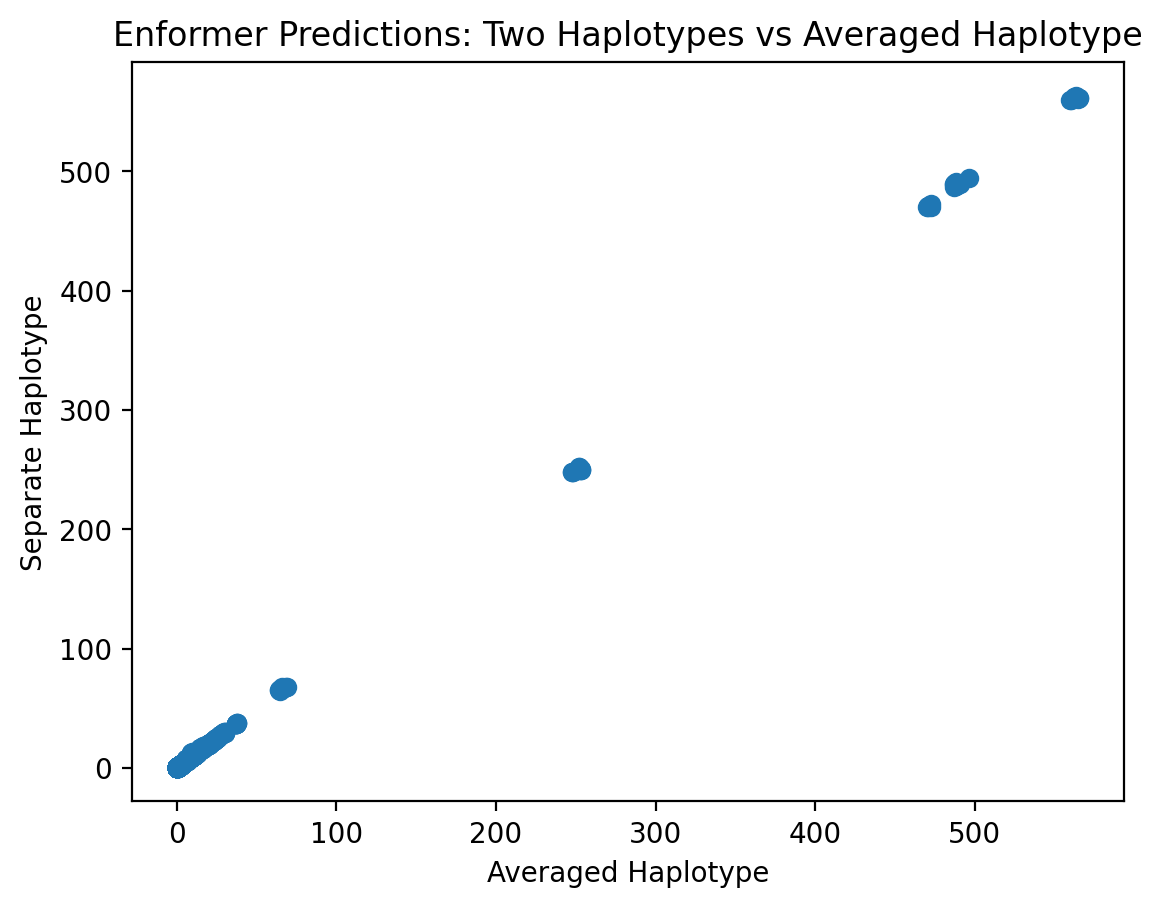

In [56]:
plt.scatter(values_avg_hapl, values_sep_hapl)
plt.xlabel("Averaged Haplotype")
plt.ylabel("Separate Haplotype")
plt.title("Enformer Predictions: Two Haplotypes vs Averaged Haplotype")

In [57]:
#calculate correlation coefficient for above plot

r = np.corrcoef(values_avg_hapl, values_sep_hapl)[0,1]
corr = np.around(r, decimals=5)
print(corr)

0.99999


The correlation is extremely close to 1, indicating that the predictions for an averaged haplotype and two separate haplotypes are pretty much the same.

## Prepare Input Data

In [58]:
geuvadis_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/5vwc7pjw9qmtv7298c4rc7bcuicoyemt.gz', sep='\t',
                                         dtype={'gene_id': str, 'gene_name':str, 'TargetID':str, 'Chr':str})
geuvadis_gene_expression.head(5)

,gene_id,gene_name,TargetID,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000223972.4,DDX11L1,ENSG00000223972.4,1,11869,0.320818,0.344202,0.354225,0.478064,-0.102815,...,1.008605,0.384489,0.581284,0.513981,0.667449,0.350890,0.186103,-0.037976,0.405439,0.199143
1,ENSG00000227232.3,WASH7P,ENSG00000227232.3,1,29806,33.714457,20.185174,18.095407,24.100871,29.018719,...,30.980194,34.086207,39.678442,29.643513,27.120420,29.121624,31.117198,32.047074,22.798959,23.563874
2,ENSG00000243485.1,MIR1302-11,ENSG00000243485.1,1,29554,0.240408,0.157456,0.218806,0.320878,0.067833,...,0.065940,0.228784,0.140642,0.283905,0.273821,0.286311,0.324060,0.049574,0.255288,0.157440
3,ENSG00000238009.2,RP11-34P13.7,ENSG00000238009.2,1,133566,0.328272,0.327932,0.090064,0.420443,0.220269,...,0.274071,0.384179,0.533693,0.307221,0.307367,0.400278,0.612321,0.666633,0.281138,1.346129
4,ENSG00000239945.1,RP11-34P13.8,ENSG00000239945.1,1,91105,0.332171,-0.032164,0.017323,0.424677,0.214025,...,0.347323,0.346744,0.073580,0.400396,0.470517,0.069749,0.299353,0.090019,0.282554,-0.157170


In [59]:
gene_intervals = collect_intervals(chromosomes=['17'], gene_list=['GSDMB'])
print(gene_intervals)


{'GSDMB': ['17', 38060848, 38077313]}


In [60]:
model = Enformer(model_path) # here we load the model architecture.

fasta_extractor = FastaStringExtractor(fasta_file) # we define a class called fasta_extractor to help us extra raw sequence data

## Predicting Separated Haplotype and Averages Haplotype Across Tracks

Pick one individual at random.

In [61]:
rand_individual = np.random.choice(a=geuvadis_gene_expression.columns[6:-1], replace=False) # individuals we are interested in
rand_individual

'NA20826'

In [62]:
gene = 'GSDMB'
gene_interval = gene_intervals[gene]
target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2])
target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))
window_coords = target_interval.resize(SEQUENCE_LENGTH)
cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/srusti/enformer/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene


In [63]:
haplo_1, haplo_2 = geno_to_seq('GSDMB', rand_individual)

haplo_1_enc = one_hot_encode("".join(haplo_1))[np.newaxis]
haplo_2_enc = one_hot_encode("".join(haplo_2))[np.newaxis]
average_enc = np.add(haplo_1_enc, haplo_2_enc) / 2

NameError: name 'geno_to_seq' is not defined

In [ ]:
prediction_1 = model.predict_on_batch(haplo_1_enc)['human'][0]
prediction_2 = model.predict_on_batch(haplo_2_enc)['human'][0]

pre_average = model.predict_on_batch(average_enc)['human'][0]
post_average = (prediction_1 + prediction_2) / 2

: 

In [ ]:
res = []
for i in range(5313):
    pre_track = pre_average[:, i]
    post_track = post_average[:, i]
    corr_all = np.corrcoef(pre_track, post_track)[0][1]
    res.append(corr_all)

: 

In [ ]:
print(min(res), max(res))

: 

The results from both methods are nearly identical across all tracks.